In [137]:
from constants import DatasetPath

import pandas as pd
import numpy as np
import torch
import timm
from torchvision import transforms
from torch import nn
from PIL import Image
from skimage import io
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [140]:
# Main Dataset folder path
DATA_DIR = DatasetPath.effectivePath

# Device to run calculations on 
DEVICE = 'cuda'

REAL_DIRS = ["afhq", "celebahq", "coco", "ffhq", "imagenet", "landscape", "lsun", "metfaces", "cycle_gan", "pro_gan"]

FAKE_DIRS = ["big_gan", "cips", "cycle_gan", "ddpm", "denoising_diffusion_gan", "diffusion_gan", "face_synthetics", 
				 "gansformer", "gau_gan", "generative_inpainting", "glide", "lama", "latent_diffusion", "mat", "palette", 
				 "pro_gan", "projected_gan", "sfhq", "stable_diffusion", "star_gan", "stylegan1", "stylegan2", "stylegan3",
				 "taming_transformer", "vq_diffusion"]

In [119]:
# Read '.csv' file containing 'anchor', 'positive' and 'negative' triplets
df = pd.read_csv(DATA_DIR + "input.csv")

# PLOT GENERATION FUNCTIONS

In [148]:
def plot_path_frequency_as_positive(df):
	"""
	Plot the frequency of paths in the 'positive' column of the DataFrame.

	This function calculates the frequency of each unique path in the 'positive'
	column of the provided DataFrame and plots the top 20 most frequent paths
	as a bar chart.

	Parameters
	----------
	df (pandas.DataFrame): the DataFrame containing the 'positive' column with paths.
	"""
	
	# Calculate the frequency of 'positive' paths
	positive_counts = df['positive'].value_counts()

	# Create the bar plot
	plt.figure(figsize=(25, 5))
	positive_counts.head(20).plot(kind='bar')
	plt.title('Most Frequent Paths as \'Positive\'')
	plt.xlabel('Path')
	plt.ylabel('Frequency')
	plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
	plt.show()

def plot_path_frequency_as_negative(df):
	"""
	Plot the frequency of paths in the 'negative' column of the DataFrame.

	This function calculates the frequency of each unique path in the 'negative'
	column of the provided DataFrame and plots the top 20 most frequent paths
	as a bar chart.

	Parameters
	----------
	df (pandas.DataFrame): the DataFrame containing the 'negative' column with paths.
	"""
	# Calculate the frequency of 'negative' paths
	negative_counts = df['negative'].value_counts()

	# Create the bar plot
	plt.figure(figsize=(25, 5))
	negative_counts.head(20).plot(kind='bar')
	plt.title('Most Frequent Paths as \'Negative\'')
	plt.xlabel('Path')
	plt.ylabel('Frequency')
	plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
	plt.show()

def plot_real_fake_count(df, dataset_partition_path):
	"""
	Plot the count of 'real' and 'fake' images based on the target information from a separate CSV file.

	This function merges the DataFrame containing image paths with another DataFrame that categorizes
	each image as 'real' or 'fake' based on the 'target' column. It then plots these counts as a horizontal bar chart.

	Parameters
	----------
	df (pandas.DataFrame): DataFrame containing 'anchor', 'positive', and 'negative' columns with image paths.
	dataset_partition_path (str): Path to the CSV file containing 'image_path' and 'target' columns.
	"""
	
	# Load the dataset partition DataFrame
	dataset_partition_df = pd.read_csv(dataset_partition_path)
	
	# Merge the anchor paths with the partition DataFrame to get their targets
	df = df.merge(dataset_partition_df, left_on='anchor', right_on='image_path', how='left')

	# Determine the 'Type' based on the 'target' column
	df['Type'] = df['target'].apply(lambda x: 'real' if x == 0 else 'fake')

	# Count occurrences of 'real' and 'fake'
	counts = df['Type'].value_counts()

	# Prepare data for plotting
	counts_df = pd.DataFrame(counts).reset_index()
	counts_df.columns = ['Type', 'Count']

	# Plot horizontal bar chart
	ax = counts_df.plot(kind='barh', x='Type', y='Count', legend=False, color=['blue', 'red'])
	plt.title('Number of images per category in the Training Set')
	plt.xlabel('Count')
	plt.ylabel('Type')

	# Add text annotations to the bars
	for index, value in enumerate(counts_df['Count']):
		ax.text(value, index, str(value), va='center')

	# Expand x-axis to accommodate annotations
	plt.xlim(right=max(counts_df['Count']) * 1.2)

	plt.show()

def plot_apn_count_by_source(train_df, apn='anchor'):
	"""
	Plots a bar chart showing the number of 'anchor' images for each source.

	Parameters
	----------
	train_df : pandas.DataFrame
		The dataframe containing the semi-hard mined triplets.
	apn : str (optional)
		'anchor', 'positive' or 'negative', specifies on which member the count should be executed. Default: 'anchor'. 
	"""

	# Count the number of images in each directory
	dir_count = {}
	for index, row in tqdm(train_df.iterrows(), total=train_df.shape[0], desc="Counting images"):
		dir = row[apn].split('/')[0]
		if dir in dir_count:
			dir_count[dir] += 1
		else:
			dir_count[dir] = 1

	# Sort the directories by name
	sorted_dirs = sorted(dir_count.items())

	# Extract the directory names and counts
	dirs, counts = zip(*sorted_dirs)

	# Create the bar chart with different colors
	colors = plt.cm.viridis(np.linspace(0, 1, len(dirs)))  # Use the viridis colormap

	# Create the bar chart
	plt.figure(figsize=(10, 6))
	plt.bar(dirs, counts, color=colors)
	plt.xlabel('Sources')
	plt.ylabel('Number of Images')
	plt.title(f'Number of \'{apn}\' Images per Source')
	plt.xticks(rotation=90)
	plt.show()


# MODEL DEFINITION

In [121]:
class APN_Model(nn.Module):
	"""
	Defines a neural network model class APN_Model that uses an EfficientNet (specifically the B0 version) as its backbone.
	"""

	def __init__(self, emb_size = 512):
		"""
		Initializes the APN_Model with a specific model and a classifier that outputs embedding vector of the specified size.

		Parameters
		----------
		emb_size (int, optional): the size of the output embedding vector (default is 512).
		"""
		super(APN_Model, self).__init__()

		# Define the model to use 
		self.efficientnet = timm.create_model('tf_efficientnetv2_b0', pretrained = True)
		
		# Replace the classifier layer with a linear layer that outputs embeddings of size `emb_size`
		self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features = emb_size)

	def forward(self, images):
		"""
		Performs the forward pass of the model, which takes a batch of images and returns their embeddings.

		Parameters
		----------
			images (torch.Tensor): a batch of images to process.

		Returns
		-------
			embeddings (torch.Tensor): a batch of embeddings of size `emb_size`.
		"""
		embeddings = self.efficientnet(images)
		return embeddings

In [122]:
# NN mod to accept greyscale fourier spectrum images instead of RGB

model = APN_Model()
model.to(DEVICE)

APN_Model(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): ConvBnAct(
          (conv): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (drop_path): Identity()
        )
      )
      (1): Sequential(
        (0): EdgeResidual(
          (conv_exp): Conv2dSame(16, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
          (bn1): BatchNormAct2d(
            64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act)

In [123]:
def getImageEmbeddings(img_path, model):
	"""
	Generates embeddings for a given image using the provided model.

	Parameters
	----------
		img_path (str): the path to the input image.
		model (torch.nn.Module): the PyTorch model used to generate the image embeddings.

	Returns
	-------
		img_enc (numpy.ndarray): the embeddings of the input image.
	"""
	preprocess = transforms.Compose([
		transforms.ToTensor(),  # Convert the image to a PyTorch tensor and normalize pixel values to [0, 1]
		transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
	])
	
	# Read the image from the specified directory
	img = Image.open(DATA_DIR + img_path).convert('RGB')
	# Image preprocessing
	img = preprocess(img).unsqueeze(0)  # Add a batch dimension
	# Move the image tensor to the appropriate device (CPU or GPU)
	img = img.to(DEVICE)
	
	# Set the model to evaluation mode
	model.eval()
	
	# Disable gradient calculation for efficiency
	with torch.no_grad():
		
		# Pass the image through the model to get the embeddings
		img_enc = model(img)
		
		# Detach the embeddings from the computation graph and move them back to the CPU
		img_enc = img_enc.detach().cpu().numpy()

	return img_enc

In [124]:
embedding_dict = {}  # Initialize an empty dictionary to store image embeddings

pre_training_df = pd.read_csv(DATA_DIR + "pre_trainingSet.csv")

# Loop through each image path in the 'anchor' column of the DataFrame
for img_path in tqdm(pre_training_df['image_path'], total=len(pre_training_df), desc="Generating embeddings"):
	# Generate and store the embedding for each anchor image in the dictionary
	embedding_dict[img_path] = getImageEmbeddings(img_path, model)

# Map the embeddings to the 'anchor_emb' column using the paths from the 'anchor' column
df['anchor_emb'] = df['anchor'].map(embedding_dict)

# Map the embeddings to the 'positive_emb' column using the paths from the 'positive' column
df['positive_emb'] = df['positive'].map(embedding_dict)

# Map the embeddings to the 'negative_emb' column using the paths from the 'negative' column
df['negative_emb'] = df['negative'].map(embedding_dict)

Generating embeddings:   0%|          | 0/48000 [00:00<?, ?it/s]

In [125]:
def euclidean_distance(a, b):
    """
    Calculate the Euclidean distance between two vectors.

    Parameters
    ----------
    a (numpy.ndarray): the first vector.
    b (numpy.ndarray): the second vector.

    Returns
    -------
    (float): the Euclidean distance between vectors `a` and `b`.
    """
    return np.linalg.norm(a - b)  # Calculate and return the Euclidean distance

In [126]:
# Calculate the distances between anchor and positive embeddings
df['dist_anchor_positive'] = [euclidean_distance(row['anchor_emb'], row['positive_emb']) for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Calculating distances (anchor-positive)")]

# Calculate the distances between anchor and negative embeddings
df['dist_anchor_negative'] = [euclidean_distance(row['anchor_emb'], row['negative_emb']) for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Calculating distances (anchor-negative)")]

Calculating distances (anchor-positive):   0%|          | 0/144000 [00:00<?, ?it/s]

Calculating distances (anchor-negative):   0%|          | 0/144000 [00:00<?, ?it/s]

In [127]:
margin = 0.2  # Set the margin for semi-hard triplets

# Filter the DataFrame to select semi-hard triplets based on the defined condition
semi_hard_triplets = df[
    (df['dist_anchor_positive'] < df['dist_anchor_negative']) &  # Check if the distance between anchor and positive embeddings is less than the distance between anchor and negative embeddings
    (df['dist_anchor_negative'] < (df['dist_anchor_positive'] + margin))  # Check if the distance between anchor and negative embeddings is less than the distance between anchor and positive embeddings plus the margin
]

# Print the semi-hard triplets
print(semi_hard_triplets)

                                                   anchor  \
6              coco/coco/coco2017/train2017/img070412.jpg   
9               coco/coco/coco2017/test2017/img016198.jpg   
13             coco/coco/coco2017/train2017/img083870.jpg   
16             coco/coco/coco2017/train2017/img104990.jpg   
32              coco/coco/coco2017/test2017/img005602.jpg   
...                                                   ...   
143965  taming_transformer/tt-ffhq/ffhq_k300_p1.0_fid9...   
143970  taming_transformer/tt-cc/cin_k600_p1.0_a0.05_f...   
143978  taming_transformer/tt-cc/cin_k600_p1.0_a0.05_f...   
143997  taming_transformer/tt-cc/cin_k600_p1.0_a0.05_f...   
143998  taming_transformer/tt-coco/samples_nopix/img00...   

                                                 positive  \
6                          lsun/horse/horse/img112555.jpg   
9         imagenet/imagenet/train/n03179701/img042102.jpg   
13        imagenet/imagenet/train/n02727426/img032818.jpg   
16        imagenet/imag

In [128]:
def df_to_csv(df, filename, path):
	"""
	Splits the DataFrame in chunks to enable tqdm progress visualization while converting the DataFrame into a '.csv' file.

	Parametres
	----------
		df (pd.DataFrame): the DataFrame to convert.
		filename (str): the desired file name (comprehensive of '.csv' extension).
		path (str): the path where the '.csv' will be stored.
	"""
	chunks = np.array_split(df.index, 100)
	for chunck, subset in enumerate(tqdm(chunks, desc="Creating \'" + filename + "\' file")):
		if chunck == 0: # first row
			df.loc[subset].to_csv(path, mode='w', index=False)
		else:
			df.loc[subset].to_csv(path, header=None, mode='a', index=False)

	print("\'" + filename + "\' has been successfully created.")

In [130]:
# Create a new DataFrame containing only the 'anchor', 'positive', and 'negative' columns from semi_hard_triplets
filtered_input_df = semi_hard_triplets[['anchor', 'positive', 'negative']].copy()

# Print the selected triplets DataFrame
print(filtered_input_df)

# Save to '.csv'
df_to_csv(filtered_input_df, "RGB_trainingSet.csv", DATA_DIR + "RGB_trainingSet.csv")

                                                   anchor  \
6              coco/coco/coco2017/train2017/img070412.jpg   
9               coco/coco/coco2017/test2017/img016198.jpg   
13             coco/coco/coco2017/train2017/img083870.jpg   
16             coco/coco/coco2017/train2017/img104990.jpg   
32              coco/coco/coco2017/test2017/img005602.jpg   
...                                                   ...   
143965  taming_transformer/tt-ffhq/ffhq_k300_p1.0_fid9...   
143970  taming_transformer/tt-cc/cin_k600_p1.0_a0.05_f...   
143978  taming_transformer/tt-cc/cin_k600_p1.0_a0.05_f...   
143997  taming_transformer/tt-cc/cin_k600_p1.0_a0.05_f...   
143998  taming_transformer/tt-coco/samples_nopix/img00...   

                                                 positive  \
6                          lsun/horse/horse/img112555.jpg   
9         imagenet/imagenet/train/n03179701/img042102.jpg   
13        imagenet/imagenet/train/n02727426/img032818.jpg   
16        imagenet/imag

Creating 'RGB_trainingSet.csv' file:   0%|          | 0/100 [00:00<?, ?it/s]

'RGB_trainingSet.csv' has been successfully created.


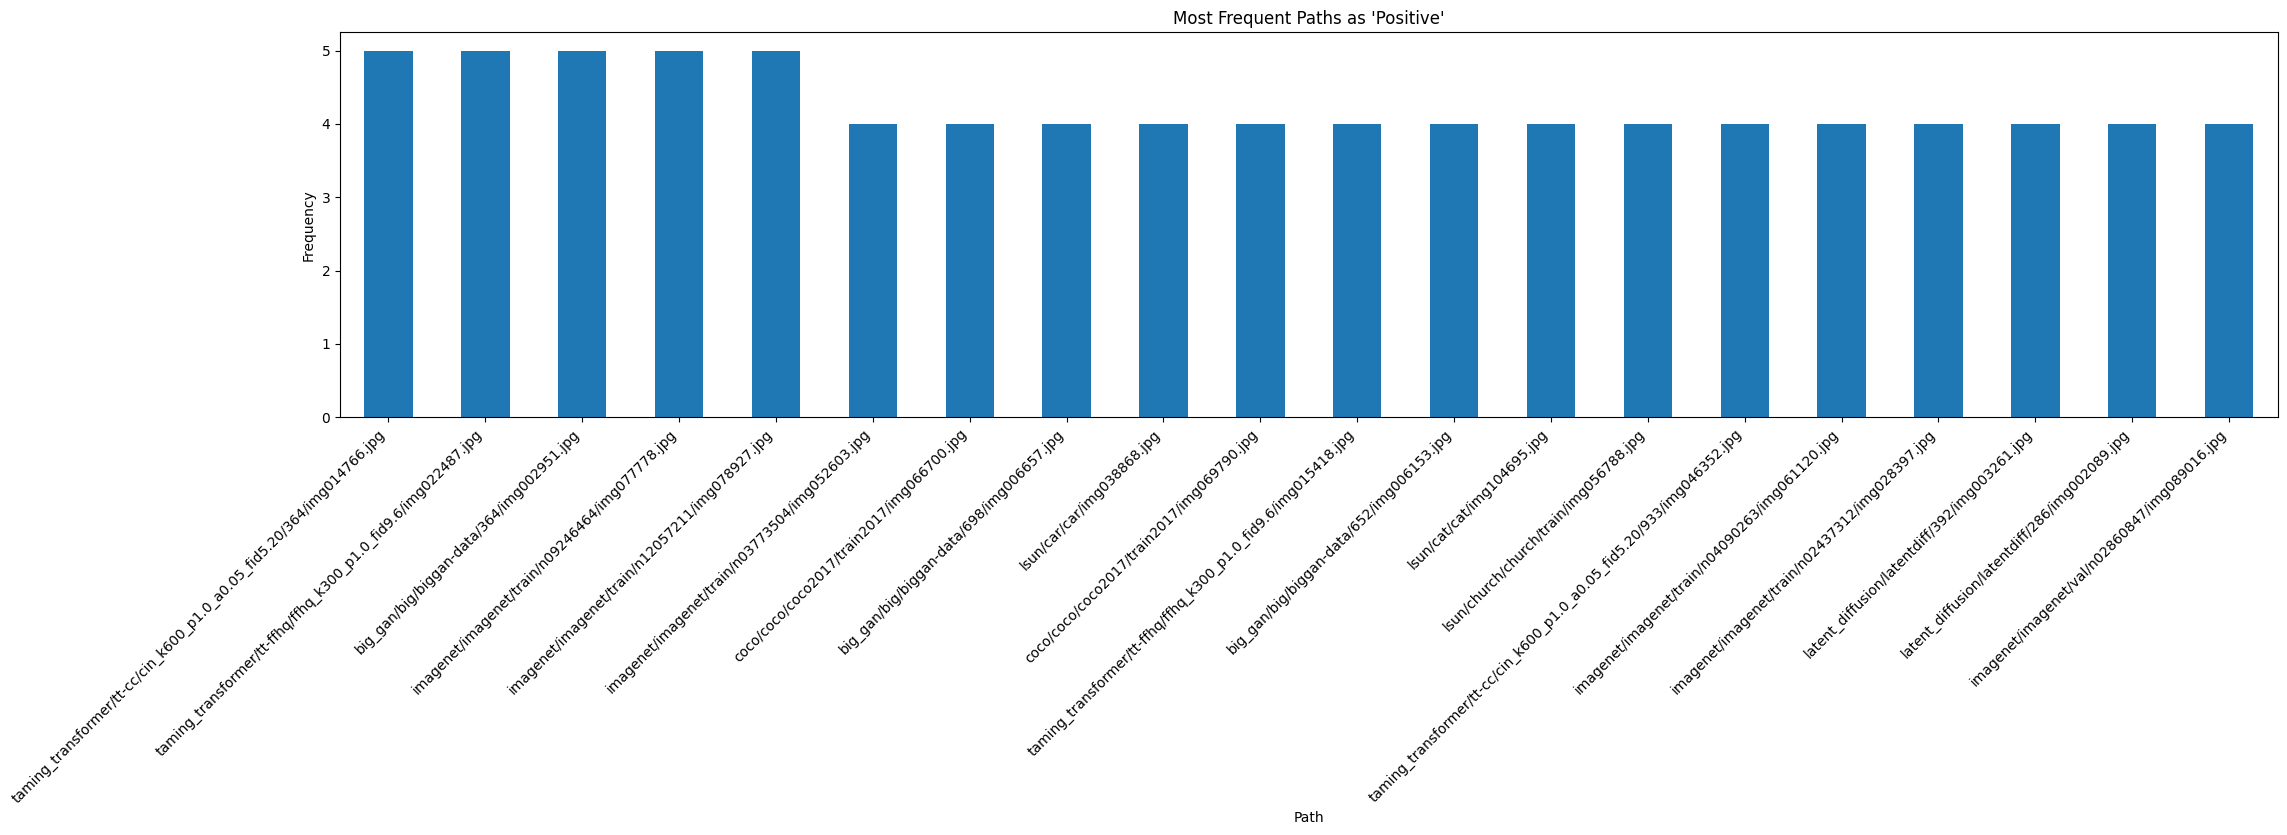

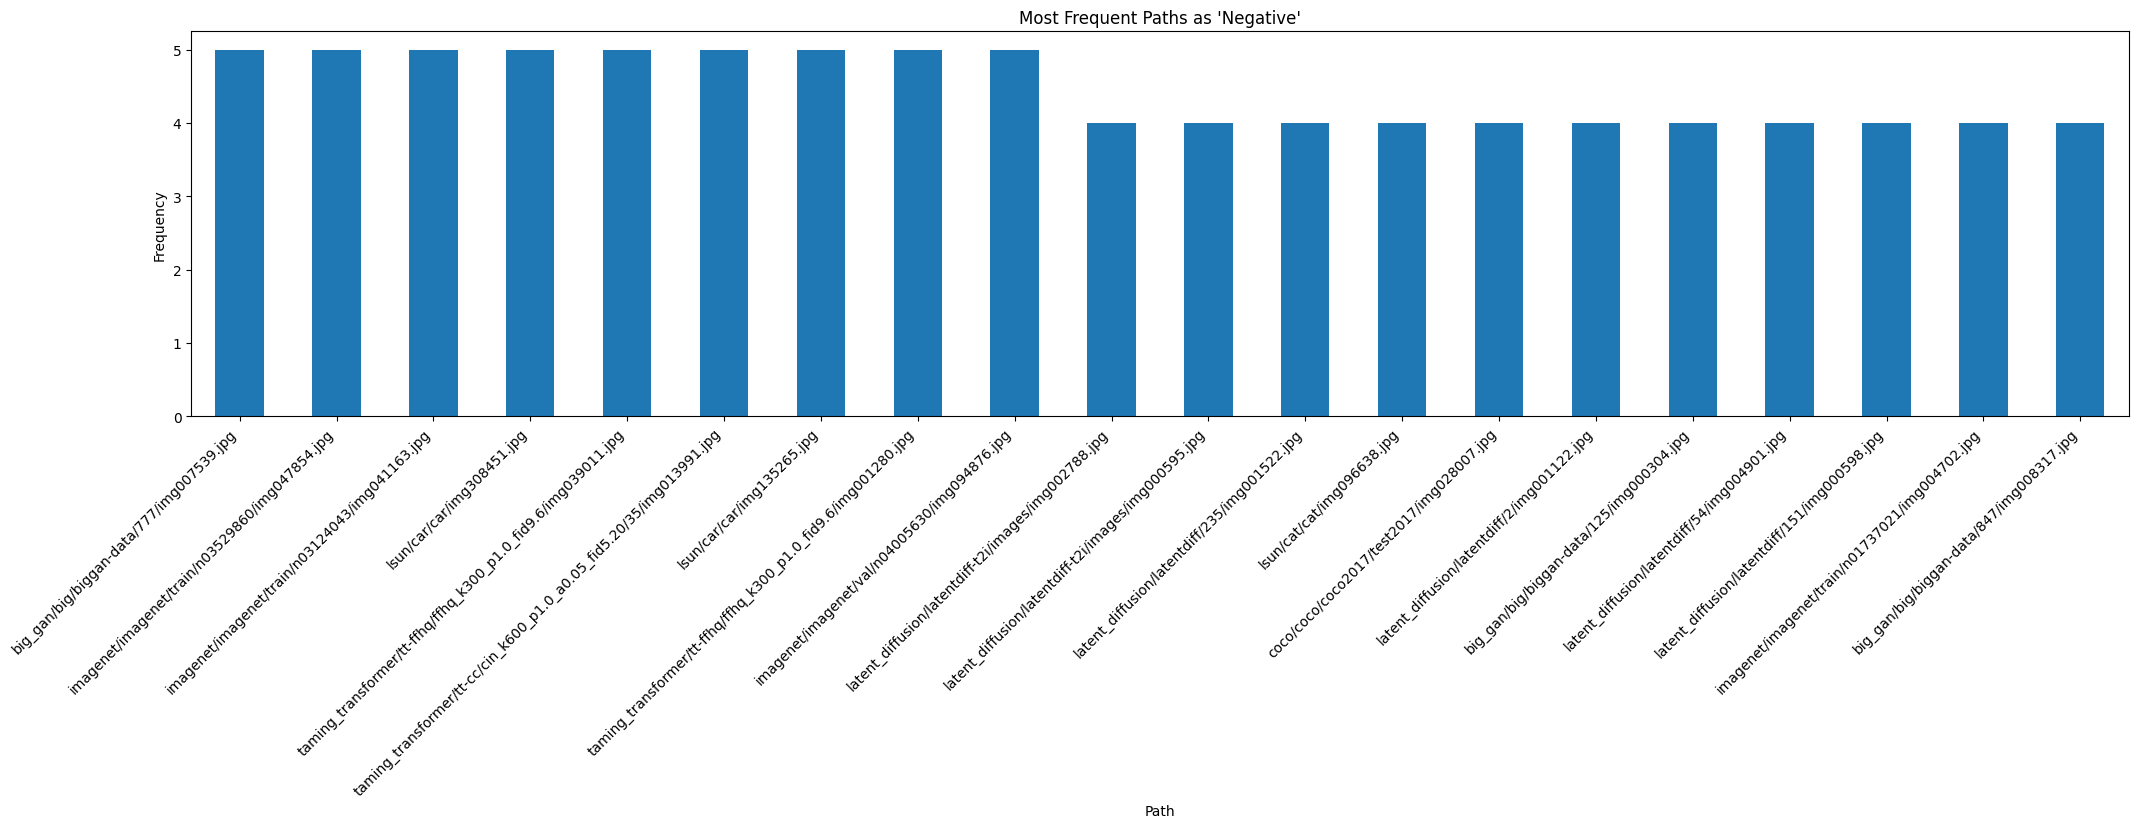

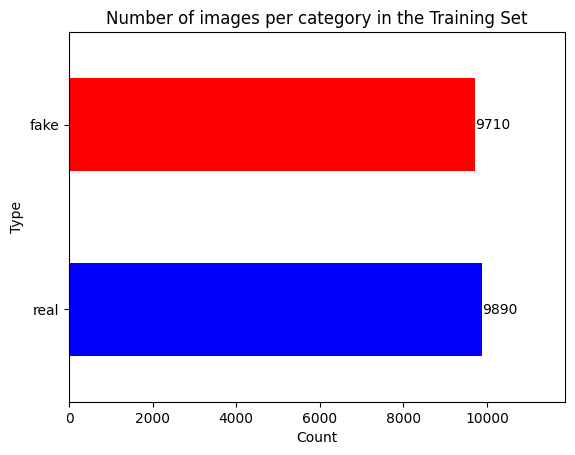

In [133]:
plot_path_frequency_as_positive(filtered_input_df)
plot_path_frequency_as_negative(filtered_input_df)
plot_real_fake_count(filtered_input_df, DATA_DIR + "pre_trainingSet.csv")

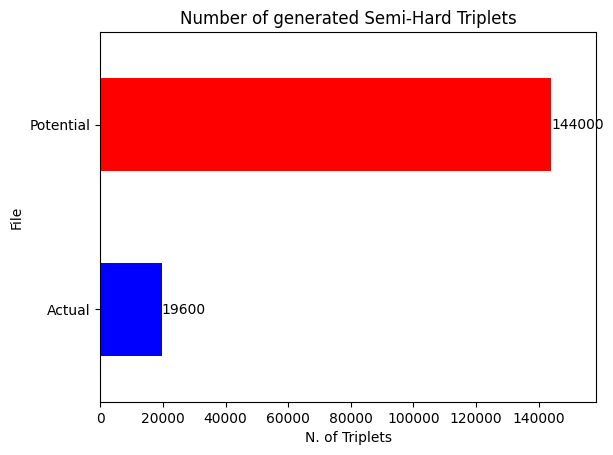

In [134]:
# Read lengths of CSV files
potential_triplets = len(df)
actual_triplets = len(filtered_input_df)

# Prepare data for plotting
lengths = {'Actual': actual_triplets, 'Potential': potential_triplets}
lengths_df = pd.DataFrame(list(lengths.items()), columns=['File', 'Length'])

# Plot horizontal bar chart
ax = lengths_df.plot(kind='barh', x='File', y='Length', legend=False, color=['blue', 'red'])
plt.title('Number of generated Semi-Hard Triplets')
plt.xlabel('N. of Triplets')
plt.ylabel('File')

# Add text annotations to the bars
for index, value in enumerate(lengths_df['Length']):
	ax.text(value, index, str(value), va='center')

# Expand x-axis to accommodate annotations
plt.xlim(right=max(lengths_df['Length']) * 1.1)

plt.show()

In [144]:
def get_input_dirs(filtered_input_df):
	"""
	Retrieves image source directories from the dataset.

	Parameters
	----------
		filtered_input_df (pandas.DataFrame): the dataframe containing the semi-hard mined triplets.
	Returns
	-------
		real_dirs (set of str): a set of unique directories that contain real images.
		fake_dirs (set of str): a set of unique directories that contain fake images.
	"""
	# Initialize lists to store directories for real and fake images
	real_dirs_list = []
	fake_dirs_list = []

	# Iterate through each row in the dataframe with a progress bar
	for index, row in tqdm(filtered_input_df.iterrows(), total=filtered_input_df.shape[0]):
		# Extract the top-level directory from the image path
		dir = row["anchor"].split('/')[0]

		# Categorize the directory as 'real' or 'fake' based on its presence in REAL_DIRS
		if dir in REAL_DIRS:
			real_dirs_list.append(dir)
		else:
			fake_dirs_list.append(dir)

	real_dirs = sorted(set(real_dirs_list))
	fake_dirs = sorted(set(fake_dirs_list))

	# Return the lists of real and fake directories
	return real_dirs, fake_dirs


def train_test_split_rebalance(train_df, test_df):
	"""
	Rebalances the test dataset to achieve an 80/20 train-test split ratio.

	This function rebalances the test dataset by dropping a calculated number of 
	samples from each directory of real and fake images to achieve an 80/20 
	train-test split ratio. The function also saves the old test set before 
	rebalancing.

	Parameters
	----------
	filtered_input_df (pandas.DataFrame): the DataFrame containing the filtered input data.
	test_df (pandas.DataFrame): the DataFrame containing the initial test data.

	Notes
	-----
	- This function assumes the presence of 'real' and 'fake' columns in the 
	  `test_df` DataFrame, which contain paths to the real and fake images, 
	  respectively.
	- The function will save the old test set to a CSV file named 
	  "unbalanced_testSet.csv" and the rebalanced test set to a CSV file named 
	  "testSet.csv" in the directory specified by `DATA_DIR`.
	- The function uses the helper function `get_input_dirs` to obtain directories 
	  containing real and fake images and `df_to_csv` to save DataFrames to CSV files.
	"""
	
	# Initialization
	balanced_test_df = pd.DataFrame(columns=['real', 'fake'])
	input_size = len(train_df)
	real_dirs, fake_dirs = get_input_dirs(train_df)
	print(real_dirs)
	print(fake_dirs)

	rebalanced_size = round(input_size * 20 / 80)
	print(f"Current Test set size:{len(test_df) * 2}(Train-Test split ratio: {(input_size * 100 / (input_size + (len(test_df)* 2))):.2f}/{(len(test_df) * 2 * 100 / (input_size + (len(test_df)* 2))):.2f})")
	print(f"Balanced Test set size:{rebalanced_size}(Train-Test split ratio: 80/20)")

	# Number of tuples to sample from each real images directory
	real_sample_size = round(rebalanced_size / 2 / len(real_dirs))
	i = 1
	#Iterate through the dataset partition and sample the same number of tuples for each fake images directory
	for dir in tqdm(real_dirs, desc="Test set Real images sampling"):
		sampled_size = 0
		for index, row in test_df.iterrows():
			if sampled_size < real_sample_size:
				image_path = row["real"]
				splitted_path = image_path.split('/')[0]
				if dir==splitted_path:
					balanced_test_df.loc[i] = [image_path, None]
					sampled_size+=1
					i+=1
			else: break
	
	# Number of tuples to sample from each fake images directory
	fake_sample_size = round(rebalanced_size / 2 / len(fake_dirs))
	i = 1
	#Iterate through the dataset partition and sample the same number of tuples for each fake images directory
	for dir in tqdm(fake_dirs, desc="Test set Fake images sampling"):
			sampled_size = 0
			for index, row in test_df.iterrows():
					if sampled_size < fake_sample_size:
							image_path = row["fake"]
							splitted_path = image_path.split('/')[0]
							if dir == splitted_path:
									balanced_test_df.loc[i] = [balanced_test_df.loc[i]["real"], image_path]
									sampled_size+=1
									i+=1

					else: break
	
	print(f"Test Set size after operations:{len(balanced_test_df) * 2}")

	# Store the old version of the Test Set and Overwrite the Test Set with the rebalanced one
	df_to_csv(test_df, "unbalanced_testSet.csv", DATA_DIR + "unbalanced_testSet.csv")
	if os.path.exists(DATA_DIR + "testSet.csv"):
		os.remove(DATA_DIR + "testSet.csv")
	df_to_csv(balanced_test_df, "testSet.csv", DATA_DIR + "testSet.csv") 

In [145]:
test_df = pd.read_csv(DATA_DIR + "testSet.csv")

train_test_split_rebalance(filtered_input_df, test_df)

  0%|          | 0/19600 [00:00<?, ?it/s]

['coco', 'imagenet', 'lsun']
['big_gan', 'latent_diffusion', 'taming_transformer']
Current Test set size:12000(Train-Test split ratio: 62.03/37.97)
Balanced Test set size:4900(Train-Test split ratio: 80/20)


Test set Real images sampling:   0%|          | 0/3 [00:00<?, ?it/s]

Test set Fake images sampling:   0%|          | 0/3 [00:00<?, ?it/s]

Test Set size after operations:4902


Creating 'unbalanced_testSet.csv' file:   0%|          | 0/100 [00:00<?, ?it/s]

'unbalanced_testSet.csv' has been successfully created.


Creating 'testSet.csv' file:   0%|          | 0/100 [00:00<?, ?it/s]

'testSet.csv' has been successfully created.


In [147]:
test_df

,real,fake
0,coco/coco/coco2017/test2017/img034161.jpg,big_gan/big/biggan-data/472/img004157.jpg
1,coco/coco/coco2017/train2017/img123159.jpg,big_gan/big/biggan-data/472/img004159.jpg
2,coco/coco/coco2017/train2017/img051061.jpg,big_gan/big/biggan-data/856/img008416.jpg
3,coco/coco/coco2017/test2017/img034059.jpg,big_gan/big/biggan-data/924/img009171.jpg
4,coco/coco/coco2017/train2017/img071200.jpg,big_gan/big/biggan-data/383/img003163.jpg
...,...,...
5995,imagenet/imagenet/val/n04005630/img094869.jpg,taming_transformer/tt-cc/cin_k600_p1.0_a0.05_f...
5996,imagenet/imagenet/train/n02093859/img014681.jpg,taming_transformer/tt-cc/cin_k600_p1.0_a0.05_f...
5997,imagenet/imagenet/train/n01534433/img001050.jpg,taming_transformer/tt-ffhq/ffhq_k300_p1.0_fid9...
5998,imagenet/imagenet/train/n03125729/img041337.jpg,taming_transformer/tt-cc/cin_k600_p1.0_a0.05_f...


Counting images:   0%|          | 0/19600 [00:00<?, ?it/s]

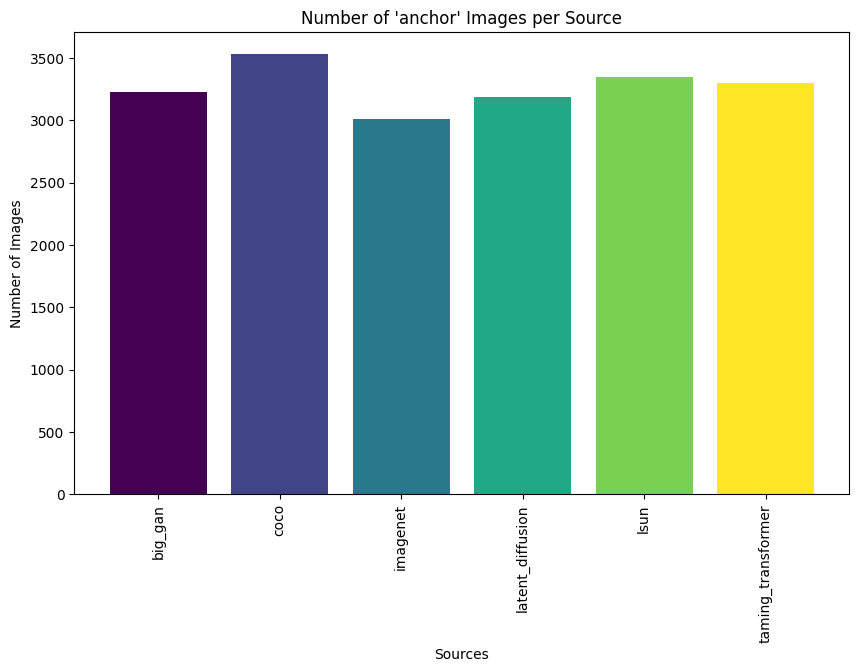

Counting images:   0%|          | 0/19600 [00:00<?, ?it/s]

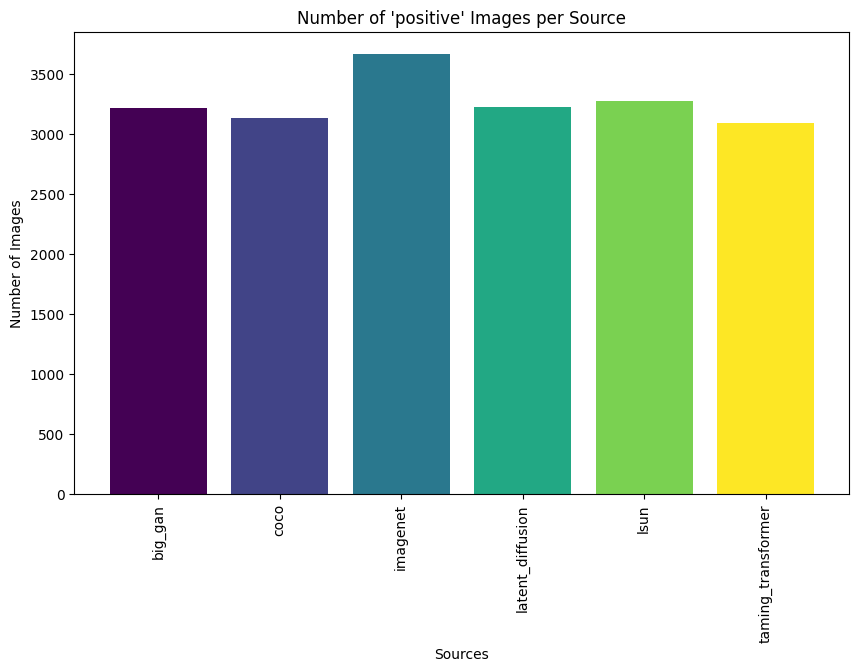

Counting images:   0%|          | 0/19600 [00:00<?, ?it/s]

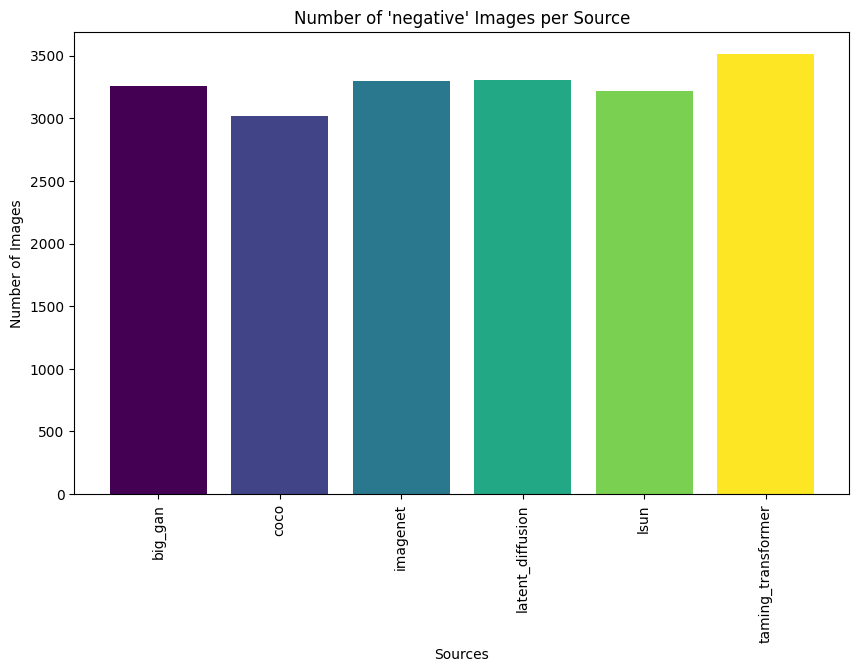

In [149]:
plot_apn_count_by_source(filtered_input_df)
plot_apn_count_by_source(filtered_input_df, 'positive')
plot_apn_count_by_source(filtered_input_df,'negative')